## Rank Decomposition
#### Replacing a full-rank matrix with a low rank approximation

In [2]:
import torch
import torch.nn as nn

In [10]:
class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, r=4, alpha =1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.r= r
        self.alpha = alpha
        self.scaling = alpha/r

        #origin frozen weight
        self.W = nn.Parameter(torch.randn(out_features, in_features), requires_grad= False)
        
        #LoRA decomposition 
        self.A = nn.Parameter(torch.randn(r, in_features) *0.01)
        self.B = nn.Parameter(torch.randn(out_features, r)*0.01)

    def forward(self, x):  # Compute W·x + B·(A·x)
        Wx = x @ self.W.T
        Ax = x @ self.A.T
        B_Ax = Ax @ self.B.T
        return Wx + self.scaling*B_Ax

In [11]:
x = torch.randn(2,512)
x

tensor([[ 0.6688, -0.4627,  0.5502,  ..., -0.2569,  0.0465,  0.4370],
        [-1.5407, -0.6858,  0.6765,  ..., -0.4732,  0.2006,  0.4749]])

In [12]:
lora = LoRALinear(in_features=512, out_features=512, r=8, alpha=16)
y = lora(x)
print(y)

tensor([[-29.5931,  23.6739,   6.6331,  ..., -58.6829,   9.6313,   5.0134],
        [ -2.2368, -21.6385,  -7.2524,  ..., -46.8917,  35.2674, -40.5402]],
       grad_fn=<AddBackward0>)


In [13]:
y.shape

torch.Size([2, 512])

## Implementing Actual LoRA using HuggingFace and fine-tune a real transformer model to evaluate performance.

In [17]:
from datasets import load_dataset
from transformers import AutoTokenizer

/opt/anaconda3/envs/tf-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Generating unsupervised split: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 1087288.92 examples/s]


In [19]:
def tokenize(df):
    return tokenizer(df["text"], truncation=True, padding = "max_length", max_length=256)

In [20]:
tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.rename_column('label', "labels")
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:06<00:00, 7398.59 examples/s]


In [21]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [22]:
#loading model with PEFT
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType

In [23]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
lora_config = LoraConfig(
    r=8,
    lora_alpha = 16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

In [25]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

'NoneType' object has no attribute 'cadam32bit_grad_fp32'
trainable params: 296,450 || all params: 109,780,228 || trainable%: 0.2700


/opt/anaconda3/envs/tf-gpu/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [26]:
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [31]:
#ALL LoRA modified layers
for name, module in model.named_modules():
    if hasattr(module, 'lora_A') and hasattr(module,'lora_B'):
        print(f"[LoRA Layer] {name}")
        for key in module.lora_A.keys():
            A = module.lora_A[key].weight
            B = module.lora_B[key].weight
            print(f"  Key: {key}")
            print(f"    A.shape: {A.shape}")
            print(f"    B.shape: {B.shape}")
            print(f"    scaling: {module.scaling}")

[LoRA Layer] base_model.model.bert.encoder.layer.0.attention.self.query
  Key: default
    A.shape: torch.Size([8, 768])
    B.shape: torch.Size([768, 8])
    scaling: {'default': 2.0}
[LoRA Layer] base_model.model.bert.encoder.layer.0.attention.self.value
  Key: default
    A.shape: torch.Size([8, 768])
    B.shape: torch.Size([768, 8])
    scaling: {'default': 2.0}
[LoRA Layer] base_model.model.bert.encoder.layer.1.attention.self.query
  Key: default
    A.shape: torch.Size([8, 768])
    B.shape: torch.Size([768, 8])
    scaling: {'default': 2.0}
[LoRA Layer] base_model.model.bert.encoder.layer.1.attention.self.value
  Key: default
    A.shape: torch.Size([8, 768])
    B.shape: torch.Size([768, 8])
    scaling: {'default': 2.0}
[LoRA Layer] base_model.model.bert.encoder.layer.2.attention.self.query
  Key: default
    A.shape: torch.Size([8, 768])
    B.shape: torch.Size([768, 8])
    scaling: {'default': 2.0}
[LoRA Layer] base_model.model.bert.encoder.layer.2.attention.self.value
  K

In [28]:
#Training model
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./lora-bert-imdb",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"].shuffle(seed=42).select(range(2000)),  # subset for quick test
    eval_dataset=tokenized["test"].select(range(500)),
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.682700,0.668049
2,0.561800,0.646079
3,0.357900,0.479176


TrainOutput(global_step=750, training_loss=0.5819360682169596, metrics={'train_runtime': 195.7621, 'train_samples_per_second': 30.649, 'train_steps_per_second': 3.831, 'total_flos': 792065249280000.0, 'train_loss': 0.5819360682169596, 'epoch': 3.0})

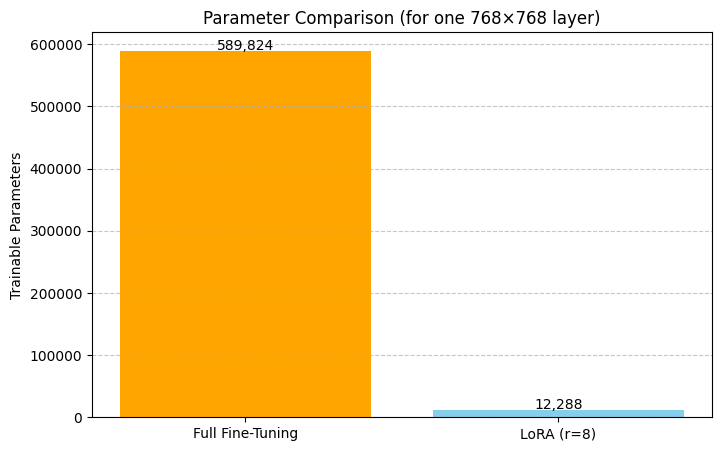

In [33]:
import matplotlib.pyplot as plt

def plot_param_comparison(d_model=768, r=8):
    full_params = d_model * d_model
    lora_params = r * (2 * d_model)  # A (r x d), B (d x r)
    
    plt.figure(figsize=(8, 5))
    plt.bar(["Full Fine-Tuning", "LoRA (r=8)"], [full_params, lora_params], color=["orange", "skyblue"])
    plt.ylabel("Trainable Parameters")
    plt.title(f"Parameter Comparison (for one {d_model}×{d_model} layer)")
    for i, val in enumerate([full_params, lora_params]):
        plt.text(i, val + 1000, f"{val:,}", ha='center', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_param_comparison()